In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Explanations: Generating Metadata for Explanations

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/tree/master/notebooks/samples/explanations/tf2/ai-explanations-image.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/tree/master/notebooks/samples/explanations/tf2/ai-explanations-image.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This tutorial shows how to generate the metadata for AI Platform Explanations service using the AI Explanations Metadata SDK. The AI Platform Explanations service is used to get feature attributions on your deployed model --explanations on how the features that contributed to the prediction.

### Dataset

The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview).

### Objective

The goal of this tutorial is to undetstand how to generate metadata using the AI Explanations Metadata SDK to obtain explanations for prediction from an image (flower) classification model. For image models, AI Explanations returns an image with the pixels highlighted that signaled your model's prediction the most.

This tutorial focuses more on deploying the model to AI Platform with Explanations than on the design of the model itself. 

### Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

* AI Platform for:
  * Prediction
  * Explanation: AI Explanations comes at no extra charge to prediction prices. However, explanation requests take longer to process than normal predictions, so heavy usage of Explanations along with auto-scaling may result in more nodes being started and thus more charges
* Cloud Storage for:
  * Storing model files for deploying to Cloud AI Platform

Learn about [AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

We will need to install the latest version of the AI Platform Explainability SDK.

In [ ]:
! pip install explainable-ai-sdk

### Restart the kernel

Once you've installed the AI Platform Explainability SDK, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

## Before you begin

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select Runtime --> Change runtime type**

This tutorial assumes you are running the notebook either in **Colab** or **Cloud AI Platform Notebooks**.

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform Training & Prediction and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Project ID

**If you don't know your project ID.**

You might able to get your project ID using `gcloud` command, by executing the second code cell below.

In [2]:
PROJECT_ID = "[your-project-id]" #@param {type:"string"}

In [3]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: andy-1234-221921


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You can
not use a Multi-Regional Storage bucket for training with AI Platform.

In [4]:
REGION = 'us-central1' #@param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

In [6]:
import sys
import os

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your Google Cloud account. This provides access
# to your Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform, then don't execute this code
if not os.path.exists('/opt/deeplearning/metadata/env_version'):
    if 'google.colab' in sys.modules:
        from google.colab import auth as google_auth
        google_auth.authenticate_user()

    # If you are running this tutorial in a notebook locally, replace the string
    # below with the path to your service account key and run this cell to
    # authenticate your Google Cloud account.
    else:
        %env GOOGLE_APPLICATION_CREDENTIALS your_path_to_credentials.json

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [7]:
BUCKET_NAME = "[your-bucket-name]" #@param {type:"string"}

In [8]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "_xai_metadata_" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [9]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://andy-1234-221921_xai_metadata_20200902155221/...


### Import libraries

Import the libraries for this tutorial.

In [10]:
import json
import random
import numpy as np
import PIL
import tensorflow as tf
import googleapiclient

from matplotlib import pyplot as plt
from base64 import b64encode

import explainable_ai_sdk as xai

# should be >= 2.1
print("Tensorflow version " + tf.__version__)
if tf.__version__ < "2.1":
    raise Exception("TF 2.1 or greater is required")

AUTO = tf.data.experimental.AUTOTUNE
print("AUTO", AUTO)

Tensorflow version 2.2.0
AUTO -1


## Download and preprocess the data

This section shows how to download the flower images, use the `tf.data` API to create a data input pipeline, and split the data into training and validation sets.

In [11]:
# GCS location of TFRecords for flowers dataset
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'

# Input size (Height, Width) for the Model
IMAGE_SIZE = [192, 192]
# Class labels for prediction
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # do not change, maps to the labels in the data (folder names)

# Batch size for training
BATCH_SIZE = 32
# Validation split for training
VALIDATION_SPLIT = 0.2


# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 32, there will be 93 batches per training epoch and 21 batch(es) per validation run.


The following cell contains some image visualization utility functions. This code isn't essential to training or deploying the model. 

If you're running this from Colab the cell is hidden. You can look at the code by right clicking on the cell --> "Form" --> "Show form" if you'd like to see it.

In [12]:
# @title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)

    if tf.executing_eagerly():
        #  In eager mode, iterate in the Dataset directly.
        for images, labels in dataset:
            numpy_images = images.numpy()
            numpy_labels = labels.numpy()
            break
    else:
        # In non-eager mode, must get the TF note that
        # yields the nextitem and run it in a tf.Session.
        get_next_item = dataset.make_one_shot_iterator().get_next()
        with tf.Session() as ses:
            numpy_images, numpy_labels = ses.run(get_next_item)

    return numpy_images, numpy_labels


def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)  # one-hot to class number
    correct_label = np.argmax(correct_label, axis=-1)  # one-hot to class number
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot + 1


def display_9_images_from_dataset(dataset):
    subplot = 331
    plt.figure(figsize=(13, 13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


def display_9_images_with_predictions(images, predictions, labels):
    subplot = 331
    plt.figure(figsize=(13, 13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

### Read images and labels from TFRecords

In this dataset each image is stored as a`tf.Example` in a `TFRecords` file, which is a serialized format for storing and retrieving training data from a disk storage. To learn more about `tf.Example` and `TFRecords`, you can view the Tensorflow documentation [here](https://www.tensorflow.org/tutorials/load_data/tfrecord).

For our purpose, each image and corresponding label is encoded as a `tf.Example` as:

- image: JPG compressed image bytes
- class: the label (class) as a scalar (integer) value
- one_hot_class: the label (class) as a one-hot encoded vector

Our helper function `read_tfrecord` takes an individual `tf.Example`, deserializes using the specification defined in the variable `features`, extracts the image bytes and corresponding label, and JPG decodes (uncompresses) the image bytes.

Our helper function `load_datasets` creates a `tf.data.Dataset` from the corresponding `TFRecords` specified by the parameter `filenames`.

In [13]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])  # explicit size will be needed for TPU
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def load_dataset(filenames):
    # Read data from TFRecords

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)  # faster
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

Use the visualization utility function provided earlier to preview flower images with their labels.

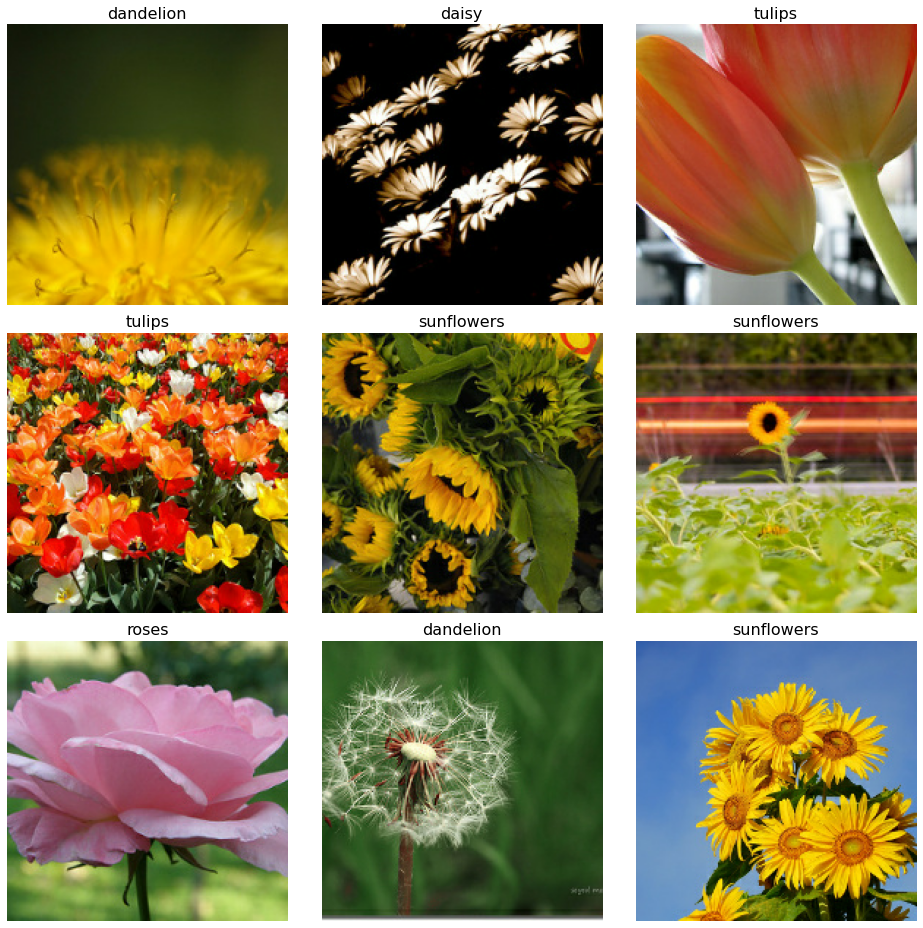

In [14]:
display_9_images_from_dataset(load_dataset(training_filenames))

### Create training and validation datasets

Next, we will use our helper functions from the previous code cell to load the training and validation data into tf.data.Datasets, and set dataset properties for:

- cache(): Reads the dataset once from disk, which is then held in memory during training.
- repeat(): Enables multiple passes over the dataset for training more than a single epoch.
- shuffle(): The number of examples to random shuffle at a time.
- batch(): The batch size for training.
- prefetch(): With AUTO setting, the dataset iterator will auto determine when/how many examples to prefetch in parallel while feeding examples for training.

Finally, we will prefetch a batch of examples from the validation dataset to use later for prediction and explainability --which we store as `some_flowers` and `some_labels`.

In [15]:
def get_batched_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.cache()  # This dataset fits in RAM
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)  # prefetch next batch while training (autotune prefetch buffer size)
    # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
    return dataset


def get_training_dataset():
    return get_batched_dataset(training_filenames)


def get_validation_dataset():
    return get_batched_dataset(validation_filenames)


some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), BATCH_SIZE)

## Build, train, and evaluate the model

This section shows how to build, train, evaluate, and get local predictions from a model by using the TF.Keras [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model).

Note that when we loaded and deserialized the `tf.Example` records, we extracted the one-hot-encoded version of the label. So when we `compile()` the model, we use `categorical_crossentropy` for the loss function.

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Stem
    Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
    BatchNormalization(),
    Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    # Conv Group
    Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(kernel_size=3, filters=96, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    # Conv Group
    Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    BatchNormalization(),

    # 1x1 Reduction
    Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),

    # Classifier
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(lr=0.005, decay=0.98),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)        2

### Train the model

Train this on a GPU if you have access (in Colab, from the menu select **Runtime** --> **Change runtime type**). On a CPU, it'll take ~30 minutes to run training. On a GPU, it takes ~5 minutes.

After the model is trained, we will print out the validation accuracy per epoch from the model's training `history`.

In [17]:
EPOCHS = 20  # Train for 60 epochs for higher accuracy, 20 should get you ~75%

history = model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=validation_steps)

print(history.history['val_accuracy'])

Epoch 1/20
93/93 [==============================] - 8s 88ms/step - loss: 1.1636 - accuracy: 0.5467 - val_loss: 2.1559 - val_accuracy: 0.2455
Epoch 2/20
93/93 [==============================] - 7s 76ms/step - loss: 0.9777 - accuracy: 0.6341 - val_loss: 2.2096 - val_accuracy: 0.2530
Epoch 3/20
93/93 [==============================] - 7s 76ms/step - loss: 0.9503 - accuracy: 0.6468 - val_loss: 2.0563 - val_accuracy: 0.2738
Epoch 4/20
93/93 [==============================] - 7s 77ms/step - loss: 0.8916 - accuracy: 0.6757 - val_loss: 1.7079 - val_accuracy: 0.3943
Epoch 5/20
93/93 [==============================] - 7s 77ms/step - loss: 0.8820 - accuracy: 0.6744 - val_loss: 1.3486 - val_accuracy: 0.4524
Epoch 6/20
93/93 [==============================] - 7s 78ms/step - loss: 0.8736 - accuracy: 0.6912 - val_loss: 1.1284 - val_accuracy: 0.5536
Epoch 7/20
93/93 [==============================] - 7s 78ms/step - loss: 0.8495 - accuracy: 0.6848 - val_loss: 0.9632 - val_accuracy: 0.6429
Epoch 8/20
93

### Visualize local predictions

Get predictions on your local model and visualize the images with their predicted labels, using the visualization utility function provided earlier.

In [18]:
# Randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(BATCH_SIZE)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

# Get predictions from our sample batch
predictions = model.predict(some_flowers, batch_size=16)
print('Predictions', np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist(), '\n')

# Get evaluations (true labels) from our sample batch
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
print('Evaluation [val_loss, val_acc]', evaluations)

Predictions ['tulips', 'sunflowers', 'dandelion', 'sunflowers', 'daisy', 'roses', 'daisy', 'tulips', 'dandelion', 'daisy', 'roses', 'sunflowers', 'sunflowers', 'roses', 'dandelion', 'roses', 'daisy', 'daisy', 'sunflowers', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'sunflowers'] 

2/2 [==============================] - 0s 5ms/step - loss: 0.8753 - accuracy: 0.6250
Evaluation [val_loss, val_acc] [0.8753181099891663, 0.625]


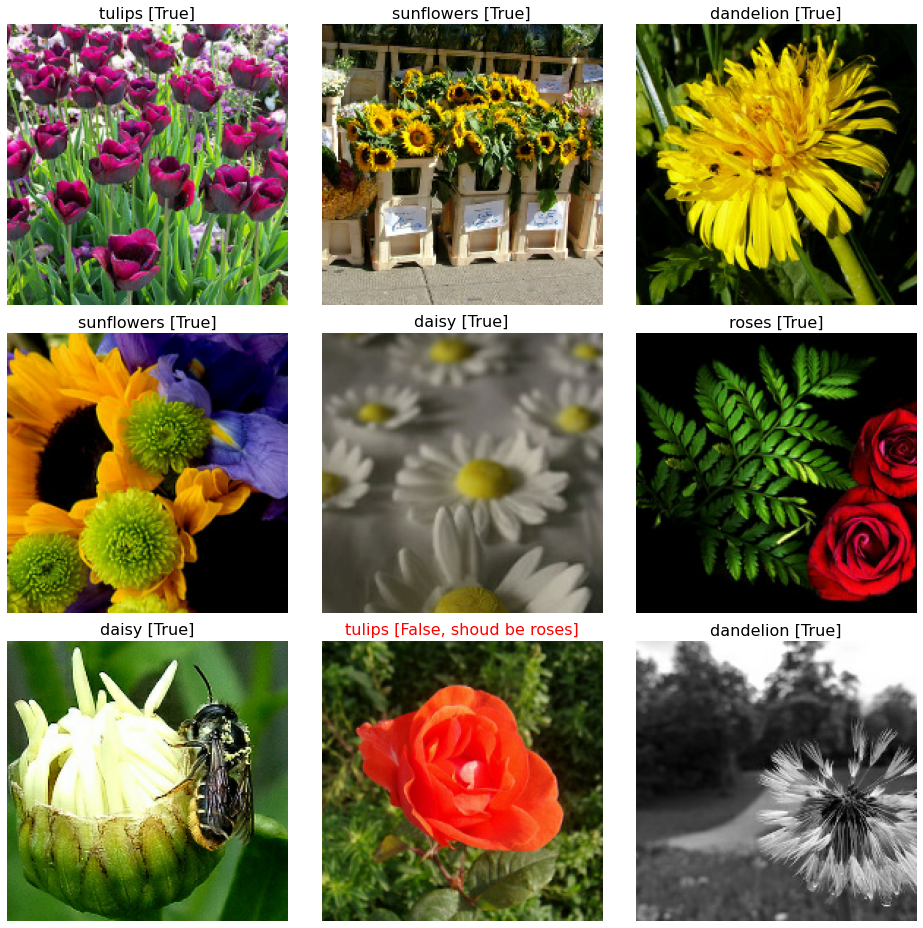

In [19]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## Export the model as a TF 2.x SavedModel

When using TensorFlow 2.x, you export the model as a `SavedModel` and load it into Cloud Storage. During export, you need to define a serving function to convert data to the format your model expects. If you send encoded data to AI Platform, your serving function ensures that the data is decoded on the model server before it is passed as input to your model.

### Serving function for image data

Sending base 64 encoded image data to AI Platform is more space efficient. Since this deployed model expects input data as raw bytes, you need to ensure that the b64 encoded data gets converted back to raw bytes before it is passed as input to the deployed model.

To resolve this, define a serving function (`serving_fn`) and attach it to the model as a preprocessing step. Add a `@tf.function` decorator so the serving function is part of the model's graph (instead of upstream on a CPU).

When you send a prediction or explanation request, the request goes to the serving function (`serving_fn`), which preprocesses the b64 bytes into raw numpy bytes (`preprocess_fn`). At this point, the data can be passed to the model (`m_call`).

In [20]:
export_path = 'gs://' + BUCKET_NAME + '/explanations/mymodel'


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(192, 192))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    with tf.device("cpu:0"):
        decoded_images = tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32)
    return {"numpy_inputs": decoded_images}  # User needs to make sure the key matches model's input


m_call = tf.function(model.call).get_concrete_function([tf.TensorSpec(shape=[None, 192, 192, 3], dtype=tf.float32, name="numpy_inputs")])


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


tf.saved_model.save(model, export_path, signatures={
    'serving_default': serving_fn,
    'xai_preprocess': preprocess_fn,  # Required for XAI
    'xai_model': m_call  # Required for XAI
})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gs://andy-1234-221921_xai_metadata_20200902155221/explanations/mymodel/assets


## Get signatures

You can get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer.

When you subsequently generate metadata for explanations, you will need the signature of the input layer to override the metadata builder defaulting to using the serving function's input signature.

In [21]:
loaded = tf.saved_model.load(export_path)

input_name = list(loaded.signatures['xai_model'].structured_input_signature[1].keys())[0]
print(input_name)

output_name = list(loaded.signatures['xai_model'].structured_outputs.keys())[0]
print(output_name)

preprocess_name = list(loaded.signatures['xai_preprocess'].structured_input_signature[1].keys())[0]
print(preprocess_name)

numpy_inputs
output_0
bytes_inputs


## Generate explanation metadata

In order to deploy this model to AI Platform Explanations, we need to create an explanation_metadata.json file with information about our model inputs, outputs, and baseline. We can automatically generate and export this file by using Metadata builder from the AI Platform Explainability SDK.

### Input baseline

For image models, using [0,1] as your input baseline represents black and white images. In this case we're using np.random to generate the baseline because our training images contain a lot of black and white (i.e. daisy petals).

Let's start by first creating the input baseline.

In [22]:
random_baseline = np.random.rand(192, 192, 3)

### Metadata builder

Next, you will instantiate an instance of SavedModelMetadatabuilder, with the parameters:

- model_path: path to the SavedModel format stored model. In this case, the path is the model stored in your Cloud Storage bucket, specified by `export_path`.
- signature_name: overrides looking at the default signature to find the input and output layers for explanations.

In [23]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
# By default models inputs and outputs are added to metadata.
builder = SavedModelMetadataBuilder(export_path, signature_name='xai_model')

Next, we set some parameters for generating the metadata with the method `set_image_metadata`, with the parameters:

- input_name: the signature of the input layer to override using the serving function.
- input_baseline: the input baseline.
- visualization: how the explanation data should be visualized.

In [24]:
# We add actual float image to explain as b64 string can't be explained.
builder.set_image_metadata(input_name, input_baselines=[random_baseline.tolist()], visualization={'type': 'Pixels', 'overlay_type': 'grayscale'})

### Upload the metadata

The last step in generating the metadata for explanations, is to upload the generated metadata json to where the stored model using the method `save_model_with_metadata`.

In [25]:
# Save the model with metadata to our GCS export path.
export_path = builder.save_model_with_metadata(export_path)

INFO:tensorflow:Assets written to: gs://andy-1234-221921_xai_metadata_20200902155221/explanations/mymodel/assets


## Deploy model to AI Explanations

This section shows how to use `gcloud` to deploy the model to AI Explanations, using two different explanation methods for image models.

### Create the model

In [26]:
import datetime
MODEL = 'flowers' + TIMESTAMP
print(MODEL)

flowers20200902155221


In [27]:
# Create the model if it doesn't exist yet (you only need to run this once)
! gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

Created ml engine model [projects/andy-1234-221921/models/flowers20200902155221].


### Create explainable model versions

For image models, we offer two choices for explanation methods: 
* Integrated Gradients (IG)
* XRAI 

You can find more info on each method in the [documentation](TODO). You can deploy a version with both so that you can compare results. **If you already know which explanation method you'd like to use, you can deploy one version and skip the code blocks for the other method.**

Creating the version will take ~5-10 minutes. Note that your first deploy may take longer.

#### Deploy an Integrated Gradients model

In [28]:
# Each time you create a version the name should be unique
IG_VERSION = 'v_ig'

In [29]:
! gcloud beta ai-platform versions create $IG_VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.2 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method integrated-gradients \
--num-integral-steps 25

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
Creating version (this might take a few minutes)......done.                    


In [30]:
# Make sure the IG model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $IG_VERSION --model $MODEL

createTime: '2020-09-02T15:58:31Z'
deploymentUri: gs://andy-1234-221921_xai_metadata_20200902155221/explanations/mymodel
etag: YVHLbBzKJjQ=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/andy-1234-221921/models/flowers20200902155221/versions/v_ig
pythonVersion: '3.7'
runtimeVersion: '2.2'
state: READY


#### Deploy an XRAI model

In [31]:
# Each time you create a version the name should be unique
XRAI_VERSION = 'v_xrai'

In [32]:
# Create the XRAI version with gcloud
! gcloud beta ai-platform versions create $XRAI_VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.2 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method xrai \
--num-integral-steps 25

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
Creating version (this might take a few minutes)......done.                    


In [33]:
# Make sure the XRAI model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $XRAI_VERSION --model $MODEL

createTime: '2020-09-02T16:03:45Z'
deploymentUri: gs://andy-1234-221921_xai_metadata_20200902155221/explanations/mymodel
etag: eT_Vl3XWs2c=
explanationConfig:
  xraiAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
machineType: n1-standard-4
name: projects/andy-1234-221921/models/flowers20200902155221/versions/v_xrai
pythonVersion: '3.7'
runtimeVersion: '2.2'
state: READY


## Get predictions and explanations

This section shows how to prepare test images to send to your deployed model, and how to send a batch prediction request to AI Explanations.

### Get and prepare test images

To prepare the test images:

- Download a small sample of images from the flowers dataset -- just enough for a batch prediction.
- Resize the images to match the input shape (192, 192) of the model.
- Save the resized images back to your bucket.

In [34]:
# Download test flowers from public bucket
! mkdir flowers
! gsutil -m cp gs://flowers_model/test_flowers/* ./flowers

mkdir: cannot create directory ‘flowers’: File exists
Copying gs://flowers_model/test_flowers/dandelion.jpg...
Copying gs://flowers_model/test_flowers/daisy.jpeg...
Copying gs://flowers_model/test_flowers/tulip.jpg...


In [35]:
# Resize the images to what your model is expecting (192,192)
test_filenames = []

for i in os.listdir('flowers'):
    img_path = 'flowers/' + i
    with PIL.Image.open(img_path) as ex_img:
        resize_img = ex_img.resize([192, 192])
        resize_img.save(img_path)
        test_filenames.append(img_path)

### Format your explanation request

Prepare a batch of instances in JSONL format.

In [36]:
# Prepare your prediction JSON to send to your Cloud model
instances = []

for image_path in test_filenames:
    img_bytes = tf.io.read_file(image_path)
    b64str = b64encode(img_bytes.numpy()).decode('utf-8')
    instances.append({preprocess_name: {'b64': b64str}})

Save the instances (batch) as a JSONL file.

### Send the explanations request

If you deployed both an IG and an XRAI model, you can request predictions for both models and compare the results.

**If you only deployed one model above, run only the cell for that explanation method.**

The following `predict_json` function sends an explain request to AI Platform Prediction.

In [37]:
# This is adapted from a sample in the docs
# Find it here: https://cloud.google.com/ai-platform/prediction/docs/online-predict#python

def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """

    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().explain(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response

In [38]:
# IG EXPLANATIONS
ig_response = predict_json(PROJECT_ID, MODEL, instances, IG_VERSION)

In [ ]:
# XRAI EXPLANATIONS
xrai_response = predict_json(PROJECT_ID, MODEL, instances, XRAI_VERSION)

### View the predicted classes

Preview the images and their predicted classes without the explanations. Why did the model predict these classes?

You can see the explanations in the next section.

In [ ]:
from io import BytesIO
import matplotlib.image as mpimg
import base64

# Note: change the `ig_response` variable below if you didn't deploy an IG model
for i, val in enumerate(ig_response['explanations']):
    class_name = CLASSES[val['attributions_by_label'][0]['label_index']]
    confidence_score = str(round(val['attributions_by_label'][0]['example_score'] * 100, 3)) + '%'
    print('Predicted class: ' + class_name + '\n' + 'Confidence score: ' + confidence_score)

    b64str = img = instances[i][preprocess_name]['b64']
    i = base64.b64decode(b64str)
    i = BytesIO(i)
    img = mpimg.imread(i, format='JPG')

    plt.imshow(img, interpolation='nearest')
    plt.show()

### Visualize the images with AI Explanations

The images returned show the explanations for only the top class predicted by the model. This means that if one of the model's predictions is incorrect, the pixels you see highlighted are for the *incorrect class*. For example, if the model predicted "rose" when it should have predicted "tulip", you can see explanations for why the model classified this image as a rose.

If you deployed an Integrated Gradients model, you can visualize its feature attributions. Currently, the highlighted pixels returned from AI Explanations show the top 60% of pixels that contributed to the model's prediction. The pixels you see after running the cell below show the pixels that most signaled the model's prediction.

In [ ]:
import io

for idx, flower in enumerate(ig_response['explanations']):
    predicted_flower = CLASSES[flower['attributions_by_label'][0]['label_index']]
    confidence = flower['attributions_by_label'][0]['example_score']
    print('Predicted flower: ', predicted_flower)
    b64str = flower['attributions_by_label'][0]['attributions'][input_name]['b64_jpeg']
    i = base64.b64decode(b64str)
    i = io.BytesIO(i)
    i = mpimg.imread(i, format='JPG')

    plt.imshow(i, interpolation='nearest')
    plt.show()

If you deployed an XRAI model, visualize the feature attributions:

In [ ]:
for idx, flower in enumerate(xrai_response['explanations']):
    predicted_flower = CLASSES[flower['attributions_by_label'][0]['label_index']]
    confidence = flower['attributions_by_label'][0]['example_score']
    print('Predicted flower: ', predicted_flower)
    b64str = flower['attributions_by_label'][0]['attributions'][input_name]['b64_jpeg']
    i = base64.b64decode(b64str)
    i = io.BytesIO(i)
    i = mpimg.imread(i, format='JPG')

    plt.imshow(i, interpolation='nearest')
    plt.show()

In [ ]:
for i, val in enumerate(ig_response['explanations']):
    baseline_score = val['attributions_by_label'][0]['baseline_score']
    predicted_score = val['attributions_by_label'][0]['example_score']
    print('Baseline score: ', baseline_score)
    print('Predicted score: ', predicted_score)
    print('Predicted - Baseline: ', predicted_score - baseline_score, '\n')

### Explain the baseline image

Another way to check your baseline choice is to view explanations for this model's baseline image: an image array of randomly generated values using np.random. First, convert the same np.random baseline array generated earlier to a base64 string and preview it. This encodes the random noise as if it's a PNG image. Additionally, you must convert the byte buffer to a numpy array, because this is the format the underlying model expects for input when you send the explain request.

In [ ]:
# Convert your baseline from above to a base64 string
rand_test_img = PIL.Image.fromarray((random_baseline * 255).astype('uint8'))
buffer = BytesIO()
rand_test_img.save(buffer, format="PNG")
new_image_string = base64.b64encode(np.asarray(buffer.getvalue())).decode("utf-8")

# Preview it
plt.imshow(rand_test_img)

In [ ]:
# Save the image to a variable in the format your model is expecting
sanity_check_img = {preprocess_name: {'b64': new_image_string}}

with open('predict.json', 'w') as outfile:
    for instance in instances:
        json.dump(sanity_check_img, outfile)
        outfile.write('\n')

Send the explanation request for the baseline image. (To check a baseline image for XRAI, change `IG_VERSION` to `XRAI_VERSION` below.)

In [ ]:
# Sanity Check explanations EXPLANATIONS
sanity_check_response = predict_json(PROJECT_ID, MODEL, instances, IG_VERSION)

Visualize the explanation for your random baseline image, highlighting the pixels that contributed to the prediction.

In [ ]:
# View explanations on the baseline random image
sanity_check_img = base64.b64decode(sanity_check_response['explanations'][0]['attributions_by_label'][0]['attributions'][input_name]['b64_jpeg'])
sanity_check_img = io.BytesIO(sanity_check_img)
sanity_check_img = mpimg.imread(sanity_check_img, format='JPG')

plt.imshow(sanity_check_img, interpolation='nearest')
plt.show()

The difference between your model's predicted score and the baseline score for this image should be close to 0. Run the following cell to confirm. If there is a difference between these two values, try increasing the number of integral steps used when you deploy your model.

In [ ]:
baseline_score = sanity_check_response['explanations'][0]['attributions_by_label'][0]['baseline_score']
example_score = sanity_check_response['explanations'][0]['attributions_by_label'][0]['example_score']

print(abs(baseline_score - example_score))

## Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can clean up individual resources by running the following
commands:

In [ ]:
# Delete model version resource
! gcloud ai-platform versions delete $IG_VERSION --quiet --model $MODEL
! gcloud ai-platform versions delete $XRAI_VERSION --quiet --model $MODEL

# Delete model resource
! gcloud ai-platform models delete $MODEL --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r gs://$BUCKET_NAME

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about AI Explanations, check out the resources here.

* [AI Explanations documentation](https://cloud.google.com/ai-platform/prediction/docs/ai-explanations/overview)
* [AI Explanations whitepaper](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)
* [XRAI paper](https://arxiv.org/abs/1906.02825)